# Pre-Processing Pipeline for Character Trajectories Dataset  

## Overview

This notebook contains the code for importing the raw CharacterTrajectories dataset and preparing it for use with a torchcde, LSTM, and RNN implementation.

In [1]:
import os
from sktime.datasets import load_from_tsfile_to_dataframe
import numpy as np
import torch

# Load the data
train_X, train_y = load_from_tsfile_to_dataframe('../../../data/raw/char_traj/CharacterTrajectories_TRAIN.ts')
test_X, test_y = load_from_tsfile_to_dataframe('../../../data/raw/char_traj/CharacterTrajectories_TEST.ts')

# Convert to NumPy arrays
train_X = train_X.to_numpy()
test_X = test_X.to_numpy()

# Concatenate the data to form a single dataset
X = np.concatenate((train_X, test_X), axis=0)   # (batch, channel)
y = np.concatenate((train_y, test_y), axis=0)   # (batch,)

# Change the labels to start from 0 and be integers
classes = np.unique(y)
y = np.array([np.where(classes == yi)[0][0] for yi in y])

# Make y a tensor
y = torch.tensor(y)

In [2]:
def _pad(channel, maxlen):
    channel = torch.tensor(channel)
    out = torch.full((maxlen,), 0, dtype=channel.dtype)
    out[:channel.size(0)] = channel
    return out

# Pad all data to same size with zeros. To be corrected for torchcde
lengths = torch.tensor([len(Xi[0]) for Xi in X])
maxlen = lengths.max()

X = torch.stack([torch.stack([_pad(channel, maxlen) for channel in batch], dim=0) for batch in X], dim=0)
X = X.transpose(-1, -2)

In [3]:
# Add time as a channel
times = [np.linspace(0, lengths[i] - 1, lengths[i]) for i in range(len(X))]
for i, time in enumerate(times):
    padding = np.zeros(maxlen - len(time))
    times[i] = np.concatenate((time, padding))

times = torch.tensor(times)

X = torch.cat((times.unsqueeze(-1), X), dim=-1)

/tmp/ipykernel_547562/3901171844.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  times = torch.tensor(times)


In [4]:
# Split the data into train and test
np.random.seed(0)

indices = np.arange(len(X))
np.random.shuffle(indices)
X_shuffled = X[indices]
y_shuffled = y[indices]

test_size = 0.2
num_test = int(test_size * len(X))

X_train, X_test = X_shuffled[:-num_test], X_shuffled[-num_test:]
y_train, y_test = y_shuffled[:-num_test], y_shuffled[-num_test:]

# Save the data
path = '../../../data/processed/CharacterTrajectories/classification'
os.makedirs(path, exist_ok=True)
torch.save(X_train, os.path.join(path, 'X_train.pt'))
torch.save(y_train, os.path.join(path, 'y_train.pt'))
torch.save(X_test, os.path.join(path, 'X_test.pt'))
torch.save(y_test, os.path.join(path, 'y_test.pt'))

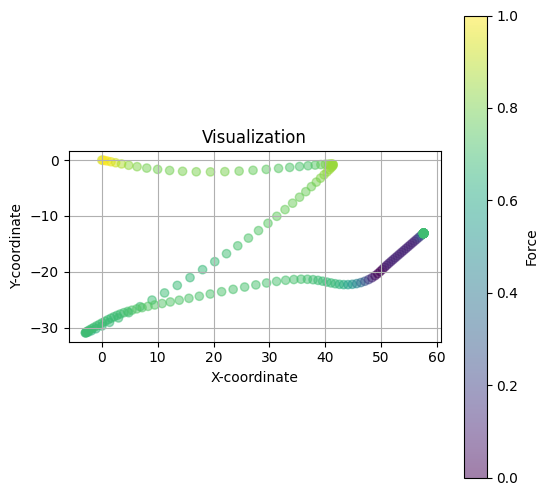

12


In [5]:
import matplotlib.pyplot as plt

index_to_character = {
    0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'g', 6: 'h', 7: 'l', 8: 'm', 9: 'n',
    10: 'o', 11: 'p', 12: 'q', 13: 'r', 14: 's', 15: 'u', 16: 'v', 17: 'w', 18: 'y', 19: 'z'
}

def plot_letter(X, index):
    x_velocities = X[index, : , 1].cpu().numpy()
    y_velocities = X[index, : , 2].cpu().numpy()
    force_values = X[index, : , 3].cpu().numpy()

    # Integrate velocities to get positions
    x_positions = np.cumsum(x_velocities)
    y_positions = np.cumsum(y_velocities)

    # Remove last element and insert 0 to the beginning
    x_positions = np.insert(x_positions[:-1],0,0)
    y_positions = np.insert(y_positions[:-1],0,0)

    # Handle NaN values by only considering non-NaN values for normalization
    non_nan_values = force_values[~np.isnan(force_values)]
    min_value = non_nan_values.min()
    max_value = non_nan_values.max()

    # Normalize non-NaN values
    force_values_normalized = (force_values - min_value) / (max_value - min_value)

    plt.figure(figsize=(6, 6))
    sc = plt.scatter(x_positions, y_positions, c=force_values_normalized, alpha=0.5)
    plt.colorbar(sc, label='Force')

    # Use the character to name the graph
    plt.title('Visualization')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.grid(True)
    plt.axis('equal')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

plot_letter(X_train, 15)
print(y_train[15].item())